In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tf2crf

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, filenames_list):
        self.sentences = []
        self.words = set()
        self.tags = set()
        for filename in filenames_list:
          with open(filename) as f:
              sentence = []
              for line in f:
                  line = line.strip()
                  if (len(line) == 0 or line.startswith("-DOCSTART-") or line.startswith("......")):
                      if len(sentence) != 0:
                        self.sentences.append(sentence)
                        sentence = []
                      continue
                  else:
                      ls = line.split(' ')
                      word, tag = ls[0],ls[3]
                      self.words.add(word)
                      self.tags.add(tag)
                      sentence.append((word,tag))

In [ ]:
#MCHP_dataset_1
files = ['/content/drive/MyDrive/MasterThesis/NER/MCHP/dataset_1/cn569258-pin.conll', '/content/drive/MyDrive/MasterThesis/NER/MCHP/dataset_2/project-13-at-2022-06-14-08-59-1d16c7ec.conll']
getter = SentenceGetter(files)
sentences = getter.sentences
words = getter.words
tags = list(getter.tags)

In [ ]:
words = list(words) #set to list convert

In [ ]:
len(words)

10007

In [ ]:
tags

['I-Pin', 'O', 'B-Pin']

In [ ]:
len(sentences)

545

In [ ]:
tags.insert(0,'PAD')

In [ ]:
n_words = len(words)
n_tags = len(tags)

In [ ]:
n_words, n_tags

(10007, 4)

In [ ]:
tags

['PAD', 'I-Pin', 'O', 'B-Pin']

In [ ]:
from future.utils import iteritems

word2idx = {w: i+1 for i, w in enumerate(words)}

word2idx["PAD"] = 0 # Padding

tag2idx = {t: i for i, t in enumerate(tags)}

idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [ ]:
tag2idx

{'PAD': 0, 'I-Pin': 1, 'O': 2, 'B-Pin': 3}

In [ ]:
#Feature and Label separation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

maxlen = max([len(s) for s in sentences])

total_feature = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=total_feature, dtype='int32', padding="post", value=word2idx["PAD"])
total_label = [[tag2idx[w[1]] for w in s] for s in sentences]
y_label = pad_sequences(maxlen=maxlen, sequences=total_label, dtype='int32', padding="post", value=tag2idx["PAD"])

Y = [to_categorical(i, num_classes=n_tags) for i in y_label]

In [ ]:
print(
        'X_tokens length:', len(X),
        '\nY_tags:', len(Y)
    )

X_tokens length: 545 
Y_tags: 545


In [ ]:
for token, tag in zip(X[0], Y[0]):
    print('%s\t%s' % (token, tag))

In [ ]:
#devide the data into train test valid
#choosing 70, 20, 10 ratio

from sklearn.model_selection import train_test_split
X_data, X_test, Y_data, y_test = train_test_split(X,Y,test_size=0.20,shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data,Y_data,test_size=0.10,shuffle=True, random_state=42)


print(
        '\X_tokens length:', len(X),
        '\ntrain_tokens length:', len(X_train),
        '\nval_tokens length:', len(X_val),
        '\ntest_tokens length:', len(X_test),
        '\n\nY_tags length:', len(Y),
        '\ntrain_tags:', len(y_train),
        '\nval_tags:', len(y_val),
        '\ntest_tags:', len(y_test)
    )

\X_tokens length: 545 
train_tokens length: 392 
val_tokens length: 44 
test_tokens length: 109 

Y_tags length: 545 
train_tags: 392 
val_tags: 44 
test_tags: 109


In [ ]:
np.array(y_test).shape

(109, 762, 4)

#Model

In [ ]:
import tensorflow

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
input_dim = n_words+1
input_length = maxlen
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  10008 
input_length:  762 
n_tags:  4


In [ ]:
import numpy as np
import tensorflow.keras as kk
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tf2crf import CRF, ModelWithCRFLoss

In [ ]:
word_embedding_size = 40

units_size = 50

#input layer
input = Input(shape=(maxlen,))

# Embedding Layer
embed = Embedding(input_dim=input_dim, output_dim=word_embedding_size, input_length=maxlen, mask_zero=True)(input)#Construct the sequence of layers-functional api

# BI-LSTM Layer
model = Bidirectional(GRU(units=units_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=kk.initializers.he_normal()))(embed)

# TimeDistributed Layer
model = TimeDistributed(Dense(units_size, activation="relu"))(model) 

# CRF Layer
crf = CRF(units=n_tags)

output = crf(model)

base_model = Model(input, output)
base_model.summary()

#***********Tf2CRF model with CRF loss implementation************#

model = ModelWithCRFLoss(base_model, sparse_target=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 762)]             0         
                                                                 
 embedding (Embedding)       (None, 762, 40)           400320    
                                                                 
 bidirectional (Bidirectiona  (None, 762, 100)         27600     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 762, 50)          5050      
 ibuted)                                                         
                                                                 
 crf (CRF)                   ((None, 762),             220       
                              (None, 762, 4),                    
                              (None,),                       

In [ ]:
from keras.callbacks import ModelCheckpoint

#Optimiser 
# adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile model
# model.compile(optimizer=adam)


model.compile(optimizer="rmsprop")



# Saving the best model only
filepath="ner-bi-gru-tf2crf-model-{accuracy:.2f}.tf"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, np.array(y_train), validation_data = (X_val, np.array(y_val)), batch_size=32, epochs=15, verbose=1, callbacks=callbacks_list)

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 175.9023 - accuracy: 0.6734
Epoch 1: accuracy improved from -inf to 0.67340, saving model to ner-bi-gru-tf2crf-model-0.67.tf


13/13 [==============================] - 78s 5s/step - loss: 175.9023 - accuracy: 0.6734 - val_loss_val: 22.3279 - val_val_accuracy: 0.9830
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 16.8826 - accuracy: 0.9868
Epoch 2: accuracy improved from 0.67340 to 0.98675, saving model to ner-bi-gru-tf2crf-model-0.99.tf


13/13 [==============================] - 52s 4s/step - loss: 16.8826 - accuracy: 0.9868 - val_loss_val: 19.9523 - val_val_accuracy: 0.9830
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 15.0550 - accuracy: 0.9868
Epoch 3: accuracy improved from 0.98675 to 0.98681, saving model to ner-bi-gru-tf2crf-model-0.99.tf


13/13 [==============================] - 53s 4s/step - loss: 15.0550 - accuracy: 0.9868 - val_loss_val: 19.1294 - val_val_accuracy: 0.9830
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 11.7308 - accuracy: 0.9869
Epoch 4: accuracy improved from 0.98681 to 0.98695, saving model to ner-bi-gru-tf2crf-model-0.99.tf


13/13 [==============================] - 57s 5s/step - loss: 11.7308 - accuracy: 0.9869 - val_loss_val: 13.9356 - val_val_accuracy: 0.9832
Epoch 5/15
13/13 [==============================] - ETA: 0s - loss: 9.6737 - accuracy: 0.9871
Epoch 5: accuracy improved from 0.98695 to 0.98713, saving model to ner-bi-gru-tf2crf-model-0.99.tf


13/13 [==============================] - 52s 4s/step - loss: 9.6737 - accuracy: 0.9871 - val_loss_val: 11.1469 - val_val_accuracy: 0.9832
Epoch 6/15
13/13 [==============================] - ETA: 0s - loss: 7.5624 - accuracy: 0.9878
Epoch 6: accuracy improved from 0.98713 to 0.98778, saving model to ner-bi-gru-tf2crf-model-0.99.tf


13/13 [==============================] - 53s 4s/step - loss: 7.5624 - accuracy: 0.9878 - val_loss_val: 8.4348 - val_val_accuracy: 0.9841
Epoch 7/15
13/13 [==============================] - ETA: 0s - loss: 5.8059 - accuracy: 0.9898
Epoch 7: accuracy improved from 0.98778 to 0.98981, saving model to ner-bi-gru-tf2crf-model-0.99.tf


13/13 [==============================] - 53s 4s/step - loss: 5.8059 - accuracy: 0.9898 - val_loss_val: 6.9532 - val_val_accuracy: 0.9872
Epoch 8/15
13/13 [==============================] - ETA: 0s - loss: 4.3241 - accuracy: 0.9919
Epoch 8: accuracy improved from 0.98981 to 0.99187, saving model to ner-bi-gru-tf2crf-model-0.99.tf


13/13 [==============================] - 52s 4s/step - loss: 4.3241 - accuracy: 0.9919 - val_loss_val: 5.9903 - val_val_accuracy: 0.9902
Epoch 9/15
13/13 [==============================] - ETA: 0s - loss: 3.8290 - accuracy: 0.9926
Epoch 9: accuracy improved from 0.99187 to 0.99257, saving model to ner-bi-gru-tf2crf-model-0.99.tf


13/13 [==============================] - 52s 4s/step - loss: 3.8290 - accuracy: 0.9926 - val_loss_val: 5.7323 - val_val_accuracy: 0.9895
Epoch 10/15
13/13 [==============================] - ETA: 0s - loss: 3.5271 - accuracy: 0.9940
Epoch 10: accuracy improved from 0.99257 to 0.99400, saving model to ner-bi-gru-tf2crf-model-0.99.tf


13/13 [==============================] - 51s 4s/step - loss: 3.5271 - accuracy: 0.9940 - val_loss_val: 9.4904 - val_val_accuracy: 0.9849
Epoch 11/15
13/13 [==============================] - ETA: 0s - loss: 3.3222 - accuracy: 0.9939
Epoch 11: accuracy did not improve from 0.99400
13/13 [==============================] - 33s 2s/step - loss: 3.3222 - accuracy: 0.9939 - val_loss_val: 5.4701 - val_val_accuracy: 0.9911
Epoch 12/15
13/13 [==============================] - ETA: 0s - loss: 2.7776 - accuracy: 0.9949
Epoch 12: accuracy improved from 0.99400 to 0.99490, saving model to ner-bi-gru-tf2crf-model-0.99.tf


13/13 [==============================] - 52s 4s/step - loss: 2.7776 - accuracy: 0.9949 - val_loss_val: 5.5696 - val_val_accuracy: 0.9907
Epoch 13/15
13/13 [==============================] - ETA: 0s - loss: 2.6044 - accuracy: 0.9951
Epoch 13: accuracy improved from 0.99490 to 0.99506, saving model to ner-bi-gru-tf2crf-model-1.00.tf


13/13 [==============================] - 52s 4s/step - loss: 2.6044 - accuracy: 0.9951 - val_loss_val: 5.2139 - val_val_accuracy: 0.9917
Epoch 14/15
13/13 [==============================] - ETA: 0s - loss: 2.4534 - accuracy: 0.9956
Epoch 14: accuracy improved from 0.99506 to 0.99555, saving model to ner-bi-gru-tf2crf-model-1.00.tf


13/13 [==============================] - 52s 4s/step - loss: 2.4534 - accuracy: 0.9956 - val_loss_val: 5.5259 - val_val_accuracy: 0.9920
Epoch 15/15
13/13 [==============================] - ETA: 0s - loss: 2.3471 - accuracy: 0.9958
Epoch 15: accuracy improved from 0.99555 to 0.99584, saving model to ner-bi-gru-tf2crf-model-1.00.tf


13/13 [==============================] - 52s 4s/step - loss: 2.3471 - accuracy: 0.9958 - val_loss_val: 5.5517 - val_val_accuracy: 0.9915


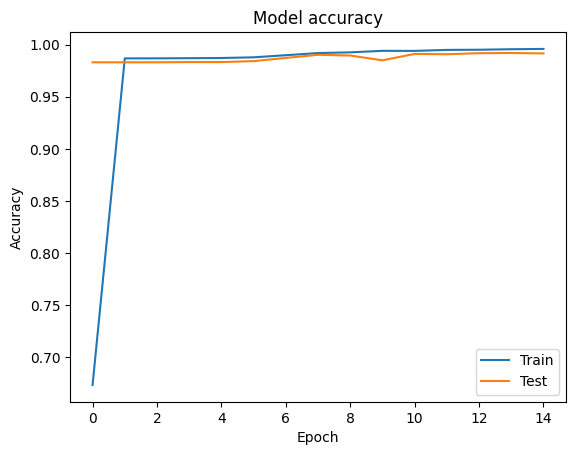

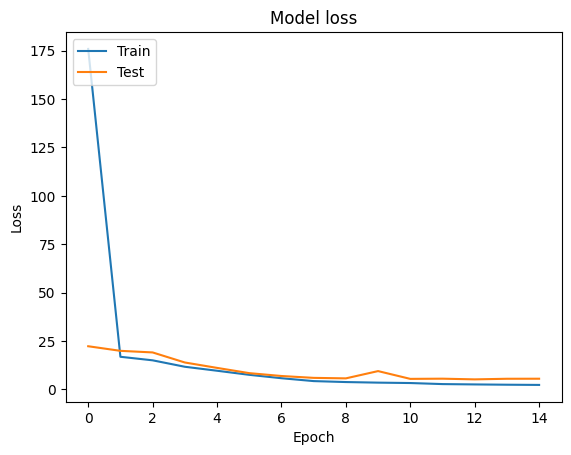

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss_val'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Prediction
pred_cat = model.predict(X_test, verbose=1)
y_te_true = np.argmax(y_test, axis=-1)

4/4 [==============================] - 2s 292ms/step


In [ ]:
!pip install sklearn_crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 19.7 MB/s eta 0:00:00


In [ ]:
#New classification report
from sklearn_crfsuite.utils import flatten
from functools import wraps


def _flattens_y(func):
    @wraps(func)
    def wrapper(y_true, y_pred, *args, **kwargs):
        y_true_flat = flatten(y_true)
        y_pred_flat = flatten(y_pred)
        return func(y_true_flat, y_pred_flat, *args, **kwargs)
    return wrapper


@_flattens_y
def flat_classification_report(y_true, y_pred, labels=None, target_names=None, **kwargs):
    """
    Return classification report for sequence items.
    """
    from sklearn import metrics
    print(labels,target_names)
    return metrics.classification_report(y_true, y_pred, labels=labels, target_names=target_names, **kwargs)

In [ ]:
#Flat Classification report
report = flat_classification_report(y_te_true, pred_cat) #imbalance data, test data doesnot have all the classes
# report = flat_classification_report(y_te_true, pred_cat, target_names=tags)
report_edited = report.replace(" 0 ", " "+idx2tag[0]+"  ").replace(" 1 ", " "+idx2tag[1]+"").replace(" 2 ", " "+idx2tag[2]+"   ").replace(" 3 ", " "+idx2tag[3]+"")
print(report_edited)

None None
              precision    recall  f1-score   support

           PAD        1.00      1.00      1.00     64447
           O         1.00      0.99      1.00     18353
           B-Pin      0.69      0.84      0.76       258

    accuracy                           1.00     83058
   macro avg       0.90      0.95      0.92     83058
weighted avg       1.00      1.00      1.00     83058



In [ ]:
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_test[i]]))
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

1/1 [==============================] - 1s 1s/step
Sample number 37 of 218 (Test Set)
Word           ||True ||Pred
identically    : O     O
(NetworkMaster : O     O
triggered.     : O     O
integrator.    : O     O
cur-           : O     O
NOT            : O     O
5-6:           : O     O
interface)     : O     O
incorporates   : O     O
cur-           : O     O
notice         : O     O
Technical      : O     O
interface)     : O     O
Center         : O     O
Restructured   : O     O
Controlled     : O     O
notice         : O     O
W              : O     O
empty          : O     O
power-up;      : O     O
Again          : O     O
stable         : O     O
3-8;           : O     O
well           : O     O
adjust2.h,     : O     O
Restructured   : O     O
inating        : O     O
find           : O     O
terminate      : O     O
CRS_CLOSE      : O     O
cur-           : O     O
))             : O     O
3-8;           : O     O
Write          : O     O
Restructured   : O     O
reset;     